# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the traffic-sign dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [1]:
%matplotlib inline

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode support bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

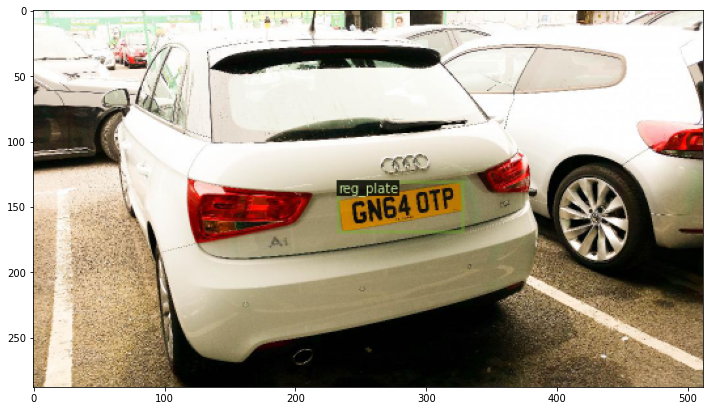

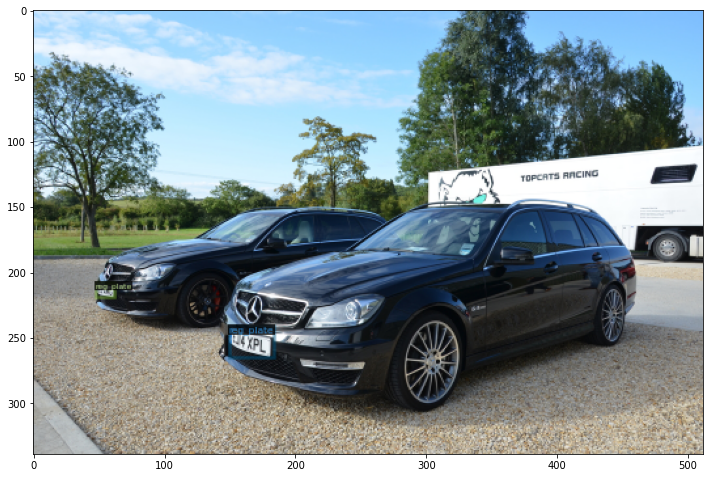

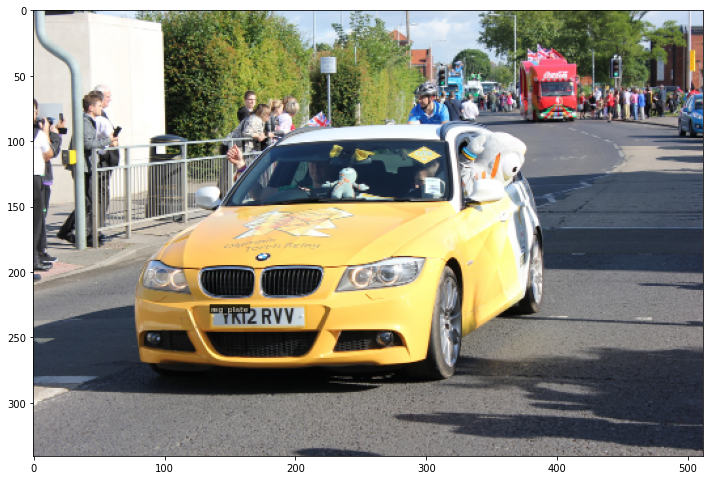

In [3]:
# write a function that loads the dataset into detectron2's standard format
def get_number_plate_dicts(data_root, txt_file):
    dataset_dicts = []
    filenames = []
    csv_path = os.path.join(data_root, txt_file)
    with open(csv_path, "r") as f:
        for line in f:
            filenames.append(line.rstrip())

    for idx, filename in enumerate(filenames):
        record = {}
        
        image_path = os.path.join(data_root, filename)
        
        height, width = cv2.imread(image_path).shape[:2]
        
        record['file_name'] = image_path
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width
        
        image_filename = os.path.basename(filename)
        image_name = os.path.splitext(image_filename)[0]
        annotation_path = os.path.join(data_root, 'labels', '{}.txt'.format(image_name))
        annotation_rows = []

        with open(annotation_path, "r") as f:
            for line in f:
                temp = line.rstrip().split(" ")
                annotation_rows.append(temp)

        objs = []
        for row in annotation_rows:
            xmin = int(float(row[1]))
            ymin = int(float(row[2]))
            xmax = int(float(row[3]))
            ymax = int(float(row[4]))
    
            obj= {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                # 'bbox': [xmin, ymin, bwidth, bheight],
                # 'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': int(row[0]),
                'iscrowd': 0
            }
        
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# configurations

data_root = 'Dataset'
train_txt = 'reg_plate_train.txt'
test_txt  = 'reg_plate_test.txt'

train_data_name = 'reg_plate_train'
test_data_name  = 'reg_plate_test'

thing_classes = ['reg_plate']

output_dir = 'outputs'

def count_lines(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

train_img_count = count_lines(os.path.join(data_root, train_txt))

# Register train and test data
# dataset can be registered only once with one name

# register train data
DatasetCatalog.register(name=train_data_name, 
                        func=lambda: get_number_plate_dicts(data_root, train_txt))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes=thing_classes)

# register test data
DatasetCatalog.register(name=test_data_name, 
                        func=lambda: get_number_plate_dicts(data_root, test_txt))
test_metadata = MetadataCatalog.get(test_data_name).set(thing_classes=thing_classes)

# lets visualize the data

test_data_dict = get_number_plate_dicts(data_root, test_txt)

for d in random.sample(test_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

In [4]:
# detectron2 configuration

# default confugration
cfg = get_cfg()

# update configuration with RetinaNet configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# We have registered the train and test data set with name traffic_sign_train and traffic_sign_test. 
# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()

# data loader configuration
cfg.DATALOADER.NUM_WORKERS = 4

# Update model URL in detectron2 config file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

# slover configuration

# batch size
cfg.SOLVER.IMS_PER_BATCH = 4

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.001

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
# lets convert number of epoch to number or iteration (max iteration)

epoch = 20
max_iter = int(epoch * train_img_count / cfg.SOLVER.IMS_PER_BATCH)
max_iter = 500

cfg.SOLVER.MAX_ITER = max_iter 

# number of output class
# we have only one class that is Traffic Sign
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)

# update create ouptput directory 
cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir outputs

Loading config /anaconda/envs/python38/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [5]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

# if rseume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

[04/09 11:53:26 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[04/09 11:54:41 d2.data.build]: Removed 0 images with no usable annotations. 5308 images left.
[04/09 11:54:42 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| reg_plate  | 7761         |
|            |              |
[04/09 11:54:42 d2.data.common]: Serializing 5308 elements to byte tensors and concatenating them all ...
[04/09 11:54:42 d2.data.common]: Serialized dataset takes 1.40 MiB
[04/09 11:54:42 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/09 11:54:42 d2.data.build]: Using training sampler TrainingSampler


'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[04/09 11:54:43 d2.engine.train_loop]: Starting training from iteration 0
[04/09 11:55:33 d2.utils.events]:  eta: 0:20:10  iter: 19  total_loss: 1.424  loss_cls: 0.975  loss_box_reg: 0.342  time: 2.5266  data_time: 0.0172  lr: 0.000020  max_mem: 3944M
[04/09 11:56:26 d2.utils.events]:  eta: 0:19:59  iter: 39  total_loss: 1.502  loss_cls: 1.053  loss_box_reg: 0.403  time: 2.5930  data_time: 0.0084  lr: 0.000040  max_mem: 4087M
[04/09 11:57:13 d2.utils.events]:  eta: 0:18:23  iter: 59  total_loss: 1.369  loss_cls: 1.034  loss_box_reg: 0.238  time: 2.5097  data_time: 0.0084  lr: 0.000060  max_mem: 4087M
[04/09 11:58:05 d2.utils.events]:  eta: 0:17:50  iter: 79  total_loss: 1.121  loss_cls: 0.941  loss_box_reg: 0.176  time: 2.5296  data_time: 0.0094  lr: 0.000080  max_mem: 4087M
[04/09 11:58:57 d2.utils.events]:  eta: 0:17:07  iter: 99  total_loss: 1.110  loss_cls: 0.818  loss_box_reg: 0.202  time: 2.5437  data_time: 0.0088  lr: 0.000100  max_mem: 4087M
[04/09 11:59:48 d2.utils.events]:  e

[Find Project3 TensorBoard logs here](https://tensorboard.dev/experiment/mCmornNpT0awIoVCOKCAHg/).

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




In [6]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# update RetinaNet score threshold 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5 #0.5

cfg.DATASETS.TEST = (test_data_name,)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)


Dataset/validation/Vehicle registration plate/efde2a25c1c9c924.jpg
{'instances': Instances(num_instances=1, image_height=680, image_width=1024, fields=[pred_boxes: Boxes(tensor([[638.0838, 429.8589, 803.1007, 479.2492]], device='cuda:0')), scores: tensor([0.8943], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


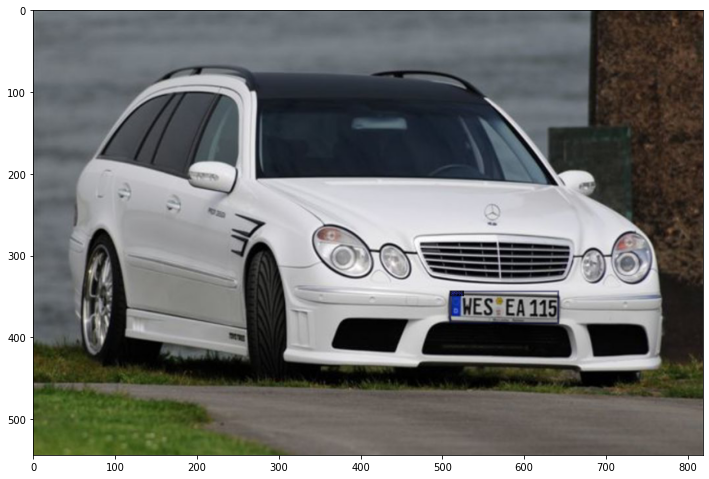

Dataset/validation/Vehicle registration plate/091c033b2a7df15b.jpg
{'instances': Instances(num_instances=2, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[224.2402, 466.9534, 252.5074, 518.9600],
        [497.9201, 207.5476, 559.0976, 260.8100]], device='cuda:0')), scores: tensor([0.7737, 0.7245], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


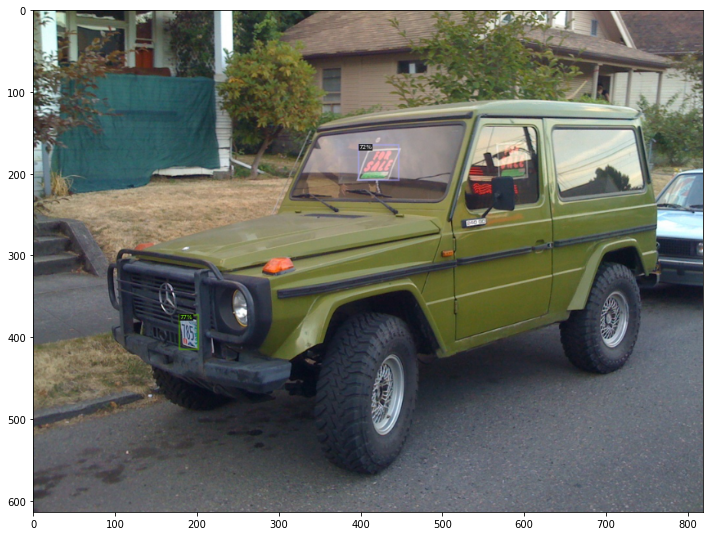

Dataset/validation/Vehicle registration plate/3d98e3713783e82d.jpg
{'instances': Instances(num_instances=1, image_height=2672, image_width=4000, fields=[pred_boxes: Boxes(tensor([[3693.6279, 1500.5159, 3929.8501, 1779.2366]], device='cuda:0')), scores: tensor([0.7336], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


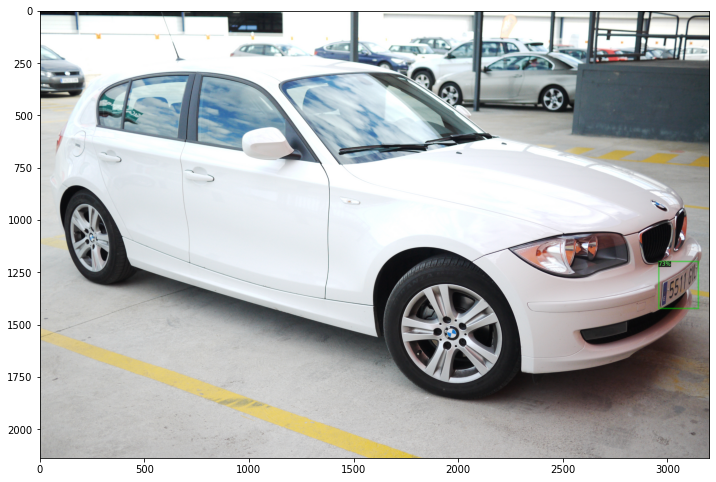

In [7]:
# let's have a look on prediction

for d in random.sample(test_data_dict, 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 12))
    plt.imshow(v.get_image())
    plt.show()

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [8]:

# create directory for evaluation
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok=True)

# create evaluator instance with coco evaluator
evaluator = COCOEvaluator(dataset_name=test_data_name, 
                          cfg=cfg, 
                          distributed=False, 
                          output_dir=eval_dir)

# create validation data loader
val_loader = build_detection_test_loader(cfg, test_data_name)

# start validation
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/09 12:16:27 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'reg_plate_test'. Trying to convert it to COCO format ...
[04/09 12:16:27 d2.data.datasets.coco]: Cached annotations in COCO format already exist: outputs/coco_eval/reg_plate_test_coco_format.json
[04/09 12:16:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| reg_plate  | 512          |
|            |              |
[04/09 12:16:32 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[04/09 12:16:32 d2.data.common]: Serialized dataset takes 0.10 MiB
[04/09 12:16:32 d2.evaluation.evaluator]: Start inference on 386 images
[04/09 12:16:36 d2.evaluation.evaluator]: Inference done 11/386. 0.3313 s / img. ETA=0:02:04
[04/09 12:16:41 d2.evaluation.evaluator]: Inference done 27/386. 0.3207 s / img. ETA=0:01:55
[04/09 12:16:47 d2.evaluation.evaluator]: Inference done 43/386. 0.3

OrderedDict([('bbox',
              {'AP': 51.01497229807263,
               'AP50': 81.08326668772669,
               'AP75': 57.427364182389276,
               'APs': 18.802347201808928,
               'APm': 61.33287387034812,
               'APl': 61.015643446004916})])

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

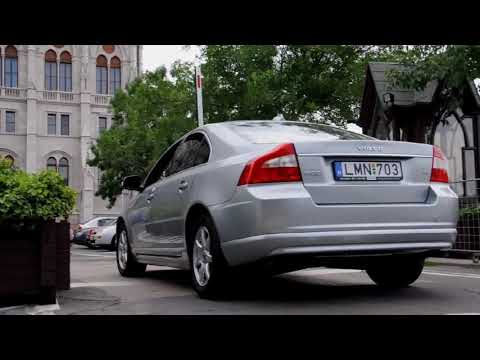

In [9]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

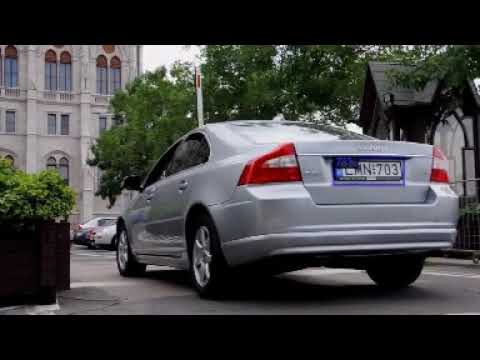

In [10]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [27]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    #output_file = cv2.VideoWriter(
    #    filename=output_fname,
    #    # some installation of opencv may not support x264 (due to its license),
    #    # you can try other format (e.g. MPEG)
    #    fourcc=cv2.VideoWriter_fourcc(*"x264"),
    #    fps=float(frames_per_second),
    #    frameSize=(width, height),
    #    isColor=True,
    #)
    
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        
        if ret:
            outputs = predictor(frame)

            #print(outputs)
            v = Visualizer(frame[:, :, ::-1],
                           metadata=test_metadata, 
                           scale=0.8
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            plt.imsave('anpd_out/frame_{}.png'.format(str(i).zfill(3)), v.get_image())
            #output_file.write(v.get_image())
            i += 1
        else:
            break
    
    img_array = []
    for iterator in range(0, i):
        img = cv2.imread('anpd_out/frame_{}.png'.format(str(iterator).zfill(3)))
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter('project3.avi',cv2.VideoWriter_fourcc(*'DIVX'), frames_per_second, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    video.release()
    #output_file.release()
    
    return

In [28]:
video_read_write('projet3-input-video.mp4')

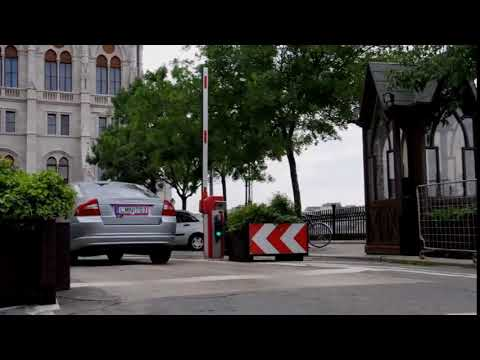

In [29]:
video = YouTubeVideo("80LslnkKlyA", width=640, height=360)
display(video)